In [2]:
#for data input and output
import numpy as np
import os
import glob
import time

#for deep learning
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LeakyReLU, Dropout
from tensorflow.keras.layers import BatchNormalization, Flatten
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Conv2DTranspose, UpSampling2D, Conv2D
from tensorflow.keras.optimizers import Adam

#for plotting
import pandas as pd
from matplotlib import pyplot as plt
import cv2
from PIL import Image
%matplotlib inline

In [3]:
filenames = glob.glob('data\*.png')
print("Number_Images: ", len(filenames))

Number_Images:  21551


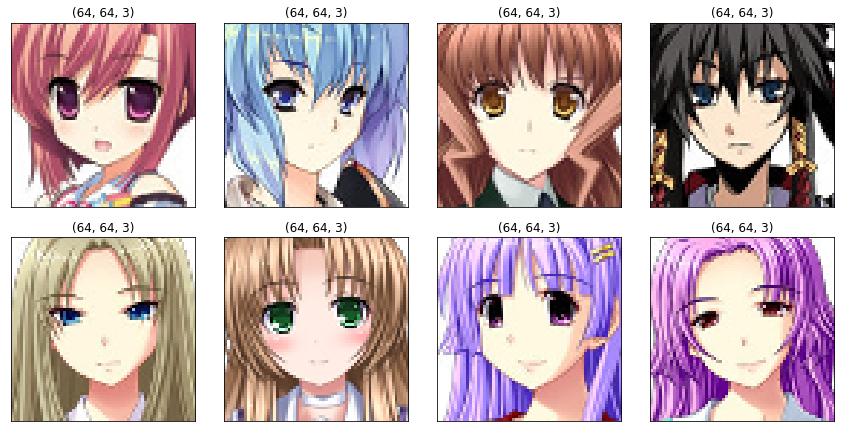

In [4]:
plt.figure(figsize=(12, 15))
for i in range(8):
    img = plt.imread(filenames[i], 0)
    plt.subplot(5, 4, i+1)
    plt.imshow(img)
    plt.title(img.shape)
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()

In [5]:
# A function to normalize image pixels.
def norm_img(img):
    '''A function to Normalize Images.
    Input:
        img : Original image as numpy array.
    Output: Normailized Image as numpy array
    '''
    img = (img / 127.5) - 1
    return img

def denorm_img(img):
    '''A function to Denormailze, i.e. recreate image from normalized image
    Input:
        img : Normalized image as numpy array.
    Output: Original Image as numpy array
    '''
    img = (img + 1) * 127.5
    return img.astype(np.uint8) 

def sample_from_dataset(batch_size, image_shape, data_dir=None):
    '''Create a batch of image samples by sampling random images from a data directory.
    Resizes the image using image_shape and normalize the images.
    Input:
        batch_size : Sample size required
        image_size : Size that Image should be resized to
        data_dir : Path of directory where training images are placed.

    Output:
        sample : batch of processed images 
    '''
    sample_dim = (batch_size,) + image_shape
    sample = np.empty(sample_dim, dtype=np.float32)
    all_data_dirlist = list(glob.glob(data_dir))
    sample_imgs_paths = np.random.choice(all_data_dirlist,batch_size)
    for index,img_filename in enumerate(sample_imgs_paths):
        image = Image.open(img_filename)
        image = image.resize(image_shape[:-1])
        image = image.convert('RGB') 
        image = np.asarray(image)
        image = norm_img(image)
        sample[index,...] = image
    return sample

In [6]:
def gen_noise(batch_size, noise_shape):
    ''' Generates a numpy vector sampled from normal distribution of shape (batch_size,noise_shape)
    Input:
        batch_size : size of batch
        noise_shape: shape of noise vector, normally kept as 100 
    Output:a numpy vector sampled from normal distribution of shape (batch_size,noise_shape)     
    '''
    return np.random.normal(0, 1, size=(batch_size,)+noise_shape)

In [7]:
def build_discriminator(image_shape=(64,64,3)):
    dropout_prob = 0.4
    kernel_init = 'glorot_uniform'
    dis_input = Input(shape = image_shape)
    filters = 64
    
    # Conv layer 1:
    disc1 = Conv2D(filters = filters * 1, kernel_size = (4,4), 
                           strides = (2,2), padding = "same", data_format = "channels_last", 
                           kernel_initializer = kernel_init)(dis_input)
    disc1 = LeakyReLU(0.2)(disc1)
    
    # Conv layer 2:
    disc2 = Conv2D(filters = filters * 2, kernel_size = (4,4), 
                   strides = (2,2), padding = "same", data_format = "channels_last", 
                   kernel_initializer = kernel_init)(disc1)
    disc2 = BatchNormalization(momentum = 0.5)(disc2)
    disc2 = LeakyReLU(0.2)(disc2)
    
    # Conv layer 3:   
    disc3 = Conv2D(filters = filters * 4, kernel_size = (4,4), 
                   strides = (2,2), padding = "same", data_format = "channels_last", 
                   kernel_initializer = kernel_init)(disc2)
    disc3 = BatchNormalization(momentum = 0.5)(disc3)
    disc3 = LeakyReLU(0.2)(disc3)
    
    # Conv layer 4:
    disc4 = Conv2D(filters = filters * 8, kernel_size = (4,4), 
                   strides = (2,2), padding = "same", data_format = "channels_last", 
                   kernel_initializer = kernel_init)(disc3)
    disc4 = BatchNormalization(momentum = 0.5)(disc4)
    disc4 = LeakyReLU(0.2)(disc4)
    
    # Flatten
    discriminator = Flatten()(disc4)
    
    # Dense Layer
    discriminator = Dense(1)(discriminator)
    
    # Sigmoid Activation
    discriminator = Activation('sigmoid')(discriminator)
    
    # Optimizer and Compiling model
    dis_opt = Adam(lr=0.0002, beta_1=0.5)
    discriminator_model = Model(inputs = dis_input, outputs = discriminator)
    discriminator_model.compile(loss='binary_crossentropy', optimizer=dis_opt, metrics=['accuracy'])
    discriminator_model.summary()
    return discriminator_model

The input images are 64 x 64 pixels in size.   This is passed to the input layer by the variables 64, 64

There are four hidden layers all of them are convolutional

The number of convultional filters per layer doubles layer by layer such that the first hidden layer has 64 convolutional filters and therefore outputs an activation map with a depth of 64, where as the fourth idden layer has 512convulitional filterscorresponding with an activation map with a depth of 512

Filter size held constant at 5x5. More filters lead to more parameters and more model complexity, but also contribute to greater sharpness in the images the GANs can produce.  

stride length for first 3 convultional layers is held at 2x2  which means the activation map's heigh and widgth are roughly halved by each of these layers.  The stride length for the last convolutional layer is 1x1 so the activation map it outputs has the same height and widgth as the activation map into it which is 4x4

Dropout forty percent(p =0.4) applied to each convultional layer 

Flatten 3 dimensional activation map from the final convolutional layer so that we can feed it into the dense output layer

Discriminating real images from fake is a binary classification task so our dense output layer consists of a single sigmoid neuron

RMSprop is an alternative to fnacy optimizer to Adam.  
The decay rate (decay,p) for RMSprop optimizer is a hyperparameter
clipvalue is a hyper parameter that prevents the gradient of learning(the partial-derivative relationship between cost and parameter values during stohastic gradient descent) fro exceeding this value; clipvaluetherby explicity limits exploding gradients. This particular value of 1.0 is common

In [18]:
def build_generator(noise_shape):
    ''' This function takes as input shape of the noise vector and creates the Keras generator    architecture.
    '''
    kernel_init = 'glorot_uniform'    
    gen_input = Input(shape = noise_shape) 
    filters = 512
    
    # Transpose 2D conv layer 1. 
    gene1 = Conv2DTranspose(filters = filters, kernel_size = (4,4), 
                                strides = (1,1), padding = "valid", data_format = "channels_last", 
                                kernel_initializer = kernel_init)(gen_input)
    gene1 = BatchNormalization(momentum = 0.5)(gene1)
    gene1 = LeakyReLU(0.2)(gene1)
    
    # Transpose 2D conv layer 2.
    gene2 = Conv2DTranspose(filters = int(filters/2), kernel_size = (4,4), 
                                strides = (2,2), padding = "same", data_format = "channels_last", 
                                kernel_initializer = kernel_init)(gene1)
    gene2 = BatchNormalization(momentum = 0.5)(gene2)
    gene2 = LeakyReLU(0.2)(gene2)
    
    # Transpose 2D conv layer 3.
    gene3 = Conv2DTranspose(filters = int(filters/4), kernel_size = (4,4), 
                                strides = (2,2), padding = "same", data_format = "channels_last", 
                                kernel_initializer = kernel_init)(gene2)
    gene3 = BatchNormalization(momentum = 0.5)(gene3)
    gene3 = LeakyReLU(0.2)(gene3)
    
    # Transpose 2D conv layer 4.
    gene4 = Conv2DTranspose(filters = int(filters/8), kernel_size = (4,4), 
                                strides = (2,2), padding = "same", data_format = "channels_last", 
                                kernel_initializer = kernel_init)(gene3)
    gene4 = BatchNormalization(momentum = 0.5)(gene4)
    gene4 = LeakyReLU(0.2)(gene4)
    
    # conv 2D layer 1.
    geneConv = Conv2D(filters = int(filters/8), kernel_size = (3,3), 
                      strides = (1,1), padding = "same", data_format = "channels_last", 
                      kernel_initializer = kernel_init)(gene4)
    geneConv = BatchNormalization(momentum = 0.5)(geneConv)
    geneConv = LeakyReLU(0.2)(geneConv)
    
    # Final Transpose 2D conv layer 5 to generate final image. Filter size 3 for 3 image channel
    generator = Conv2DTranspose(filters = 3, kernel_size = (4,4), 
                                strides = (2,2), padding = "same", data_format = "channels_last", 
                                kernel_initializer = kernel_init)(geneConv)
    
    # Tanh activation to get final normalized image
    generator = Activation('tanh')(generator)
    
    # defining the optimizer and compiling the generator model.
    gen_opt = Adam(lr=0.00015, beta_1=0.5)
    generator_model = Model(inputs = gen_input, outputs = generator)
    generator_model.compile(loss='binary_crossentropy', optimizer=gen_opt, metrics=['accuracy'])
    generator_model.summary()
    return generator_model

Specify the number of dimensions in the input noise vector as 32.  Is a hyperparameter
A higher dimensional noise vector has the capacity to store more information and thus can imporve the quality of the GAN's fake-image output, however this comes at the cost of increased computational complexity.  Recommended experimenting with varying this hyperparmeter by multiples of 2.

The input is the random noise array with a length corresponding to latent dim, which is this case 32

The first hidden layer is dense layer.  This fully connected layer enables the latentspace input to be flexibly mapped to the spatial de-covolutional hidden layers that follow. 

The 32 input dimensions are mapped to 3136 neurons in the dense layer, which outputs a one-dimensional array of activations.  These activations are then reshaped into 7 x 7 64 activation map. This dense layer is the only layer the generator where dropout is applied 

The Network has 3 de-convolutional layers 

First has 32 filters, and this number is halved successively in the remaining two layers.  While the number of filters decreases, the size of the filters increases thanks to the upsampling layers.  Each time upsampling is applied both heigh and width ofthe activation map double.

All 3 convolutional layers follow
5x5 filter size
stride 1x1 the default
Padding set to sam to maintain the dimensions of the activation maps after de-convolution
ReLu activation functions
Batch normalization to promote regularization

The output layer is a convolutional layer that collapses the 28x 28x 8 activation into a single 28 x 28 x 1 image 
Sigmoid ensures pixel ranges from 0 to 1 just ike the data from real images that we feed into the discriminator seperately.  

In [19]:
!mkdir imagesanime

A subdirectory or file imagesanime already exists.


In [20]:
# Shape of noise vector to be input to the Generator
noise_shape = (1,1,100)
# Number of steps for training. num_epochs = num_steps*batch_size/data_size
num_steps = 2000
# batch size for training.
batch_size = 64
# Location to save images and logs 
img_save_dir = "imagesanime/"
# Image size to reshape to
image_shape = (64,64,3)
# Location of data directory
data_dir = "data/*.png"
# set up log and save directories
log_dir = img_save_dir
save_model_dir = img_save_dir

In [21]:
def save_img_batch(img_batch,img_save_dir):
    '''Takes as input a image batch and a img_save_dir and saves 16 images from the batch in a 4x4 grid in the img_save_dir
    '''
    plt.figure(figsize=(16,16))
    gs1 = gridspec.GridSpec(4, 4)
    gs1.update(wspace=0, hspace=0)
    rand_indices = np.random.choice(img_batch.shape[0],16,replace=False)
    for i in range(16):
        ax1 = plt.subplot(gs1[i])
        ax1.set_aspect('equal')
        rand_index = rand_indices[i]
        image = img_batch[rand_index, :,:,:]
        fig = plt.imshow(denorm_img(image))
        plt.axis('off')
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)
    plt.tight_layout()
    plt.savefig(img_save_dir,bbox_inches='tight',pad_inches=0)
    plt.show()

In [22]:
discriminator = build_discriminator(image_shape)
generator = build_generator(noise_shape)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 32, 32, 64)        3136      
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 16, 16, 128)       131200    
_________________________________________________________________
batch_normalization_7 (Batch (None, 16, 16, 128)       512       
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 8, 8, 256)         5245

In [23]:
#adverserial model architecture
discriminator.trainable = False

# Optimizer for the GAN
opt = Adam(lr=0.00015, beta_1=0.5) #same as generator
# Input to the generator
gen_inp = Input(shape=noise_shape)

GAN_inp = generator(gen_inp)
GAN_opt = discriminator(GAN_inp)

# Final GAN
gan = Model(inputs = gen_inp, outputs = GAN_opt)
gan.compile(loss = 'binary_crossentropy', optimizer = opt, metrics=['accuracy'])

In [ ]:
# Use a fixed noise vector to see how the GAN Images transition through time on a fixed noise. 
fixed_noise = gen_noise(16,noise_shape)

# To keep Track of losses
avg_disc_fake_loss = []
avg_disc_real_loss = []
avg_GAN_loss = []

# We will run for num_steps iterations
for step in range(num_steps): 
    tot_step = step
    print("Begin step: ", tot_step)
    # to keep track of time per step
    step_begin_time = time.time() 
    
    # sample a batch of normalized images from the dataset
    real_data_X = sample_from_dataset(batch_size, image_shape, data_dir=data_dir)
    
    # Genearate noise to send as input to the generator
    noise = gen_noise(batch_size,noise_shape)
    
    # Use generator to create(predict) images
    fake_data_X = generator.predict(noise)
    
    # Save predicted images from the generator every 10th step
    if (tot_step % 100) == 0:
        step_num = str(tot_step).zfill(4)
        save_img_batch(fake_data_X,img_save_dir+step_num+"_image.png")
    
    # Create the labels for real and fake data. We don't give exact ones and zeros but add a small amount of noise. This is an important GAN training trick
    real_data_Y = np.ones(batch_size) - np.random.random_sample(batch_size)*0.2
    fake_data_Y = np.random.random_sample(batch_size)*0.2
        
    # train the discriminator using data and labels
    
    discriminator.trainable = True
    generator.trainable = False

    # Training Discriminator seperately on real data
    dis_metrics_real = discriminator.train_on_batch(real_data_X,real_data_Y) 
    # training Discriminator seperately on fake data
    dis_metrics_fake = discriminator.train_on_batch(fake_data_X,fake_data_Y) 
    
    print("Disc: real loss: %f fake loss: %f" % (dis_metrics_real[0], dis_metrics_fake[0]))
    
    # Save the losses to plot later
    avg_disc_fake_loss.append(dis_metrics_fake[0])
    avg_disc_real_loss.append(dis_metrics_real[0])
    
    # Train the generator using a random vector of noise and its labels (1's with noise)
    generator.trainable = True
    discriminator.trainable = False

    GAN_X = gen_noise(batch_size,noise_shape)
    GAN_Y = real_data_Y
   
    gan_metrics = gan.train_on_batch(GAN_X,GAN_Y)
    print("GAN loss: %f" % (gan_metrics[0]))
    
    # Log results by opening a file in append mode
    text_file = open(log_dir+"\\training_log.txt", "a")
    text_file.write("Step: %d Disc: real loss: %f fake loss: %f GAN loss: %f\n" % (tot_step, dis_metrics_real[0], dis_metrics_fake[0],gan_metrics[0]))
    text_file.close()

    # save GAN loss to plot later
    avg_GAN_loss.append(gan_metrics[0])
            
    end_time = time.time()
    diff_time = int(end_time - step_begin_time)
    print("Step %d completed. Time took: %s secs." % (tot_step, diff_time))
    
    # save model at every 500 steps
    if ((tot_step+1) % 500) == 0:
        print("-----------------------------------------------------------------")
        print("Average Disc_fake loss: %f" % (np.mean(avg_disc_fake_loss))) 
        print("Average Disc_real loss: %f" % (np.mean(avg_disc_real_loss))) 
        print("Average GAN loss: %f" % (np.mean(avg_GAN_loss)))
        print("-----------------------------------------------------------------")
        discriminator.trainable = False
        generator.trainable = False
        # predict on fixed_noise
        fixed_noise_generate = generator.predict(noise)
        step_num = str(tot_step).zfill(4)
        save_img_batch(fixed_noise_generate,img_save_dir+step_num+"fixed_image.png")
        generator.save(save_model_dir+str(tot_step)+"_GENERATOR_weights_and_arch.hdf5")
        discriminator.save(save_model_dir+str(tot_step)+"_DISCRIMINATOR_weights_and_arch.hdf5")

Begin step:  0


In [ ]:
def generate_images(generator, save_dir):
    noise = gen_noise(batch_size,noise_shape)
    fake_data_X = generator.predict(noise)
    print("Displaying generated images")
    plt.figure(figsize=(16,16))
    gs1 = gridspec.GridSpec(4, 4)
    gs1.update(wspace=0, hspace=0)
    rand_indices = np.random.choice(fake_data_X.shape[0],16,replace=False)
    for i in range(16):
        ax1 = plt.subplot(gs1[i])
        ax1.set_aspect('equal')
        rand_index = rand_indices[i]
        image = fake_data_X[rand_index, :,:,:]
        fig = plt.imshow(denorm_img(image))
        plt.axis('off')
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)
    plt.tight_layout()
    plt.savefig(save_dir+str(time.time())+"_GENERATEDimage.png",bbox_inches='tight',pad_inches=0)
    plt.show()

generate_images(generator, img_save_dir)

In [ ]:
disc_real_loss = np.array(avg_disc_real_loss)
disc_fake_loss = np.array(avg_disc_fake_loss)
GAN_loss = np.array(avg_GAN_loss)

# Plot the losses vs training steps
plt.figure(figsize=(16,8))
plt.plot(range(0,num_steps), disc_real_loss, label="Discriminator Loss - Real")
plt.plot(range(0,num_steps), disc_fake_loss, label="Discriminator Loss - Fake")
plt.plot(range(0,num_steps), GAN_loss, label="Generator Loss")
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.title('GAN Loss')
plt.grid(True)
plt.show()

In [1]:
#Generating GIF from PNGs
import imageio
# create a list of PNGs
generated_images = [img_save_dir+str(x).zfill(4)+"_image.png" for x in range(0,num_steps,100)]

NameError: name 'num_steps' is not defined

In [ ]:
images = []
for filename in generated_images:
    images.append(imageio.imread(filename))

imageio.mimsave(img_save_dir+'movie.gif', images)

In [ ]:
from IPython.display import Image
with open("images/movie.gif",'rb') as f:
    display(Image(data=f.read(), format='png'))

In [ ]:
z = Input(shape=(z_dimensions,))
img = generator(z)
discriminator.trainable = False
pred = discriminator(img)
adversarial_model = Model(z, pred)

We use Input() to define the models input z which will be an array of random noise of length 32

Passing z into generator returns 28x28 image output that we call img

For the purposes of generator training the parameters of our discriminator network must be frozen, so we set the discriminators trainable attribute to False. 

We pass the fake img into frozen discriminator network, which outputs a prediction(pred) as to whther the image is real or fake.

Finally, using the Keras functional API's Model class, we construct the Adveserial model.  By indicating that the adverserial model input is z and its output is pred, the functional API determines that the adversarial network consists of the generator passing img into the discriminator.  



N.B.: Bizarrely, if you're using a CPU only to train your model (i.e., you're not using a GPU), then the RMSprop optimizer nearly always fails to train the discriminator. Instead of compiling the discriminator with RMSprop you could compile it with AdaGrad or Adam, as in the following (commented out) cell block.

In [ ]:
adversarial_model.compile(loss='binary_crossentropy', 
                          optimizer=RMSprop(lr=0.0004, 
                                            decay=3e-8, 
                                            clipvalue=1.0), 
                          metrics=['accuracy'])

Learning rate and decay is halved.   Delicate balance to be struck between the rate at which the discriminator and the generator learns in order GAN to produce compelling fake images.  

If you were to adjus tthe optimizer hyperparams of the discriminator model when compiling it, then you might find that you'd also need to adjust them for the advesarial model in order to produce satisfacotry image outputs.

The discriminator is not frozen across the board it is only frozen when its a component of the adversarial model.  

In this way during discriminator training the wieghs are updated during backpropagation and the model learns to distiguish between real and fake images.  

The discriminator is the exact same model with the same weights, but when the advesarial model learns it does not update the discriminator weights, it only updates the weights of the generator

In [ ]:
#Gan Training 
def train(epochs=10000, batch=128, z_dim=z_dimensions):
    
    d_metrics = []
    a_metrics = []
    
    running_d_loss = 0
    running_d_acc = 0
    running_a_loss = 0
    running_a_acc = 0
    
    for i in range(epochs):
        
        # sample real images: 
        real_imgs = np.reshape(
            X_train[np.random.choice(X_train.shape[0],
                                  batch,
                                  replace=False)],
            (batch,64,64,3))
        
        # generate fake images: 
        fake_imgs = generator.predict(
            np.random.uniform(-1.0, 1.0, 
                              size=[batch, z_dim]))
        
        # concatenate images as discriminator inputs:
        x = np.concatenate((real_imgs,fake_imgs))
        
        # assign y labels for discriminator: 
        y = np.ones([2*batch,1])
        y[batch:,:] = 0
        
          # train discriminator: 
        d_metrics.append(
            discriminator.train_on_batch(x,y)
        )
        running_d_loss += d_metrics[-1][0]
        running_d_acc += d_metrics[-1][1]
        
        # adversarial net's noise input and "real" y: 
        noise = np.random.uniform(-1.0, 1.0, 
                                  size=[batch, z_dim])
        y = np.ones([batch,1])
        
        # train adversarial net: 
        a_metrics.append(
            adversarial_model.train_on_batch(noise,y)
        ) 
        running_a_loss += a_metrics[-1][0]
        running_a_acc += a_metrics[-1][1]
        
        # periodically print progress & fake images: 
        if (i+1)%100 == 0:

            print('Epoch #{}'.format(i))
            log_mesg = "%d: [D loss: %f, acc: %f]" % \
            (i, running_d_loss/i, running_d_acc/i)
            log_mesg = "%s  [A loss: %f, acc: %f]" % \
            (log_mesg, running_a_loss/i, running_a_acc/i)
            print(log_mesg)

            noise = np.random.uniform(-1.0, 1.0, 
                                      size=[16, z_dim])
            gen_imgs = generator.predict(noise)

            plt.figure(figsize=(5,5))
            
            for k in range(gen_imgs.shape[0]):
                plt.subplot(4, 4, k+1)
                plt.imshow(gen_imgs[k, :, :, 0])
                plt.axis('off')
                
            plt.tight_layout()
            plt.show()
    
    return a_metrics, d_metrics


N.B.: Running the next cell leads to the following warning in recent versions of Keras:

Discrepancy between trainable weights and collected trainable weights, did you set model.trainable without calling model.compile after ?

This warning can be safely ignored. In most neural networks, you should indeed ensure that you compile the model after adjusting whether the models weights are trainable or not. In a GAN, however, this is unnecessary: The discriminator need not be compiled after making its weights untrainable; instead, we compile these untrainable weights as a part of the adversarial model. You can read more about this unnecessary warning here and here. If the warning really bothers you though, we created a GAN notebook with an awkward workaround here.

In [ ]:
#train the GAN:
a_metrics_complete, d_metrics_complete = train()

The two empty lists d_metrics and four variables set to 0 are for tracking loss and accuracy metrics for he discrimantor d and adversiral networks a as they train

Use for loop to train however many epochs we'd like. More accurate to call it batch.  During each iteration of for loop we will sample only 128 sketches from out datset of the population of sketches

Within each epoch we altnerate between discriminator training and generator training

To train the discriminator

Sample batch 128 real images

Generate 128 fake images by creating noise vectors(z, sampled unifromly over the range -1.0, 1.0 and passing them into generators model predict method.  Using predict method the generator is only performing infernece, it is generating images without updating its parameters.

Cocatenate the real and fake images into a single variable x, which will serve as the input into our discriminator. 

Create an array, y, to label the images as real(y = 1) or fake (y = 0) so that they can be used to trian the discriminator.

To train the discriminator we pass our inputs x and labels y into model's train_on_batch method

after each round of training, the training loss and accuracy are appended to the d_metrics list.




To train the generator:


Pass the random noise vectors stored in a variable called noise as inputs as well as an array (y) of all real labels into the train_on batch method of the adveserial model.

The generator component of the advesarial model converts the noise inputs into fake images, which are automatically passed as inputs into the discriminator component of the advesarial model.

Because the discriminator parameters are frozen during advesarial model traiing.

The discriminator will simply tell us whether it thins the incoming images are reak or fake.  Even though the generator outputs fakes, they are labeld as real and the cross-entropy cost is used during backpropgation to update the weights of the generator model.  By minimizing this cost the generator should learn to produce fake images that the discrimnator erroneously classfies as real.

After each round of training, the advesarial loss and accuracy metrics are appended to the a_metrics list.

After every 100 epochs we:
    
    print the epochs that we are in
    
    print a log message that includes the discriminator and adversarial models' running loss and accuracy metrics
    
    Randomly sample 16 noise vectors and use the generator's predict method to generate fake images, which are stored in gen_imgs
    
    plot the 16 fake images in the 4x4 grid so that we can monitor the quality of the generator's images during the training.
    
At the conclusion of the train function, we return the list of adversiarial model and discrimniator model metrics

Finally we call the train function saving the metrics into a_metric_complete and d_metric complete variables as training progresses.  



Hopeful results

As the generator component of the adversarial network model began to produce higher-quality fakes the discriminator's task of discerning real images from fake ones becomes more difficultand so the loss rises.  

To a certain point the discriminator model improvedas its binary classification task corresponding to a gentle decrease in training loss and increase in training accuracy

In [ ]:
#plottig Gans training loss

ax = pd.DataFrame(
    {
        'Adversarial' : [metric[0] for metric in a_metrics_complete],
        'Discriminator' : [metric[0] for metric in d_metrics_complete],
        }
).plot(title = 'Training Loss', logy = True)
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')

In [ ]:
#plotting our gan training accuracy
ax = pd.DataFrame(
    {
        'Adversarial' : [metric[1] for metric in a_metrics_complete],
        'Discriminator' : [metric[1] for metric in d_metrics_complete],
        }
).plot(title = 'Training Accuracy')
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')